## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [61]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import timeit
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df[df['converted']== 1].shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [4]:
df.query('group == "treatment" and landing_page !="new_page"').shape[0] + df.query('group != "treatment" and landing_page =="new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [3]:
index1 = df[((( df.group == 'treatment')&( df.landing_page != 'new_page'))|(( df.group =='control')&(df.landing_page!='old_page')))].index
df2 = df.drop(index1)

In [4]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [5]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [6]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [7]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [7]:
df2.drop( 2893 ,inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [8]:
df2[df2['converted']==1].shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [37]:
control_df = df2[df2['group']=='control']
p_control = control_df[control_df['converted']==1].shape[0]/control_df.shape[0]
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [38]:
treat_df = df2[df2['group']=='treatment']
p_treat = treat_df[treat_df['converted']==1].shape[0]/treat_df.shape[0]
p_treat

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

In [9]:
#save new dataframe
df2.to_csv('new_ab_data.csv', index=False)

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**In A/B dataset the probability of Individual converting is 12%. The probaility of individual receiving new page is 50%. Although the convertion rate in control group is greater than the convertion rate in treatment group but the difference is nearly approximate. Still there is no strong evidence to conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**<center>$H_{0}$ : $p_{new}$ - $p_{old}$ <= 0</center>**
<br>
**<center>$H_{1}$ : $p_{new}$ - $p_{old}$ > 0</center>**


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [10]:
#Read cleaned CSV File
df_3 = pd.read_csv('new_ab_data.csv')
df_3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [48]:
p_new = df_3[df_3['converted']==1].shape[0]/df_3.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [49]:
p_old = df_3[df_3['converted']==1].shape[0]/df_3.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [50]:
n_new = df_3[df_3['group']=='treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [51]:
n_old = df_3[df_3['group']=='control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [52]:
new_page_converted = np.random.choice([0,1], n_new,p=[p_new,(1- p_new)])
new_page_converted

array([1, 1, 1, ..., 1, 0, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [53]:
old_page_converted = np.random.choice([0,1], n_old, p=[p_old, 1-p_old])
old_page_converted

array([1, 1, 0, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [60]:
new_page_converted.mean() - old_page_converted.mean()

0.0015097070995618855

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [34]:
start = timeit.default_timer()
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1], n_new,p=[p_new,(1- p_new)])
    old_page_converted = np.random.choice([0,1], n_old, p=[p_old, 1-p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.array(p_diffs)
stop = timeit.default_timer()
print("Execution Time: {}".format(stop-start))

Execution Time: 66.85023663900029


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0,0.5,'Distribution')

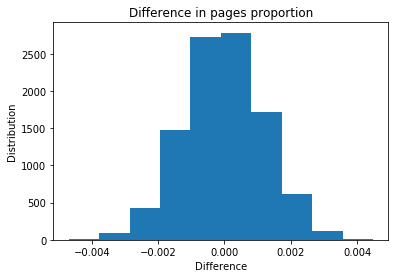

In [35]:
plt.hist(p_diffs)
plt.title("Difference in pages proportion")
plt.xlabel("Difference")
plt.ylabel("Distribution")

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [39]:
#calculate the original difference between treatment and control
observed_diff = p_treat - p_control
#calculate p_value
(p_diffs > observed_diff).mean()

0.9042

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In the previous step we calculated the p-value which is "the probaility of obtaining the data or more extreme values from the null hypothesis". And the result was 0.9,which is greater than alpha. Then based on this result We fail to reject the Null.**
<br>
**We stay with the Null hypothesis. which means that the Old page is better than or equal in convertion rate than the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
import statsmodels.api as sm

convert_old = control_df[control_df['converted']== 1].shape[0]
convert_new = treat_df[treat_df['converted']== 1].shape[0]
n_old = control_df.shape[0]
n_new = treat_df.shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [41]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**the previous cell calculate the proportion based on normal z-test. and it returns z-score which is the test statistics(how many standard deviation from the mean) and p_value of the test. The p-value is almost the same in z-test and the calculation in parts j&k .**
<br>
**we are 1.3 std far from the mean value. P-value is 0.9 which is greater than alpha.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**
<br>
**Our response variable is categorical,so it is better to use Logistic regression as we are predicting only two possible outcome( conversion or no conversion).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [63]:
df_3['intercept'] = 1
df_3['ab_page'] = pd.get_dummies(df_3['landing_page'])['new_page']
df_3.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
133218,700704,2017-01-19 13:44:46.367459,treatment,new_page,0,1,1
9622,923350,2017-01-13 20:14:00.503268,control,old_page,0,1,0
46711,756696,2017-01-14 12:26:26.138452,control,old_page,0,1,0
168893,893099,2017-01-06 21:42:19.505989,treatment,new_page,0,1,1
164140,723032,2017-01-15 19:48:19.059296,treatment,new_page,0,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [67]:
log_model = sm.Logit(df_3['converted'], df_3[['intercept','ab_page']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [73]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-05 14:48 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**In the previous model the p_value is 0.19, which is different from p_value in part II.**
<br>
**In the previous model we are predicting convertion in new page. Although in part II we assumed the null hypothes as old page has higher conversion rate than new page or the same.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**In our dataset we cannot add group column to our model as it's dependent variable to Landing_page. but we can add timestamp and convert it to categorical values based on days or timing and use dummy variables to use it in model which is complex.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [74]:
countries_df = pd.read_csv('countries.csv')
countries_df.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [78]:
#Cobine original dataframe and countries dataframe based on user_id
combined_df = df_3.join(countries_df.set_index('user_id'), on='user_id',how='left' )

In [81]:
combined_df.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US


In [82]:
combined_df.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [83]:
#create dummy variables for country
combined_df[['CA','UK','US']]= pd.get_dummies(combined_df['country'])
#create logistic model
log_model = sm.Logit(combined_df['converted'], combined_df[['intercept','CA','UK']])
results = log_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-05 15:19 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [84]:
#get the exponential for each variable
np.exp(results.params)

intercept    0.135779
CA           0.960018
UK           1.009966
dtype: float64

In [85]:
1/_

intercept    7.364925
CA           1.041647
UK           0.990133
dtype: float64

**A user from US is 0.99 more likely to make a conversion rate than a user in UK**
<br>
**A user from US is 1.04 more likely to make a conversion rate than a user in CA**
<br>
**Differences in values between countries based on conversion rate are approximate to 1.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [86]:
#Creating model between country and page to see their impact on conversion
log_model = sm.Logit(combined_df['converted'], combined_df[['intercept','CA','UK','ab_page']])
results = log_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-05 15:42 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

In [87]:
np.exp(results.params)

intercept    0.136795
CA           0.960062
UK           1.009932
ab_page      0.985168
dtype: float64

In [88]:
1/_

intercept    7.310207
CA           1.041599
UK           0.990165
ab_page      1.015056
dtype: float64

**When adding new page column and countries to the model the convertion of the countries stays the same as the model for country only.**

# Conclusion
   - A/B data shows the data for convertion either for experiment/treatment user who experience the new page or the control user who use old page.Our first analysis shows that the proportion of user who converted in cntrol group was 12%, on the other hand the proportion of user who converted in the treatment group was 11.9%.The convertion rate in both group is nearly approximate.keeping in mind the probability of user who received new page was 0.5.
   - In Hypothesis testing by defult we assume the null is true. We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. In hypothesis test we got a p-value equal to 0.9, based on this result We fail to reject the Null.
   - Our response variable is categorical,so we used Logistic regression as we are predicting only two possible outcome( conversion or no conversion).In our first model we were predicting convertion in new page. So we got p-value of 0.19 which was different from p-value in the previous hypothesis part. In the second model we predicted conversion rate based on country of user, Differences in values between countries based on conversion rate are approximate to 1, so there is no preferences in country.
   - Based on these different tests, we recommend to stay with old page or make more improvent to enhance convertion rate. 

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!




## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0